# Generating train, validation and test sets with similar class label distributions

## Module imports

In [1]:
import sys
import os
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme()

# cyberpunk theme
import mplcyberpunk
plt.style.use('cyberpunk')

import numpy as np
from scipy.stats import entropy

from sklearn.model_selection import train_test_split


# project-specific custom functions
## export the path to custom modules
sys.path.append("../functions")
## import functions
from preprocessing import import_image_files, import_images_from_file_list

## Data import

In [2]:
dir_data_relative = "../data/"  # the relative directory path to all data files

### label information
df__labels = pd.read_csv(dir_data_relative+"train_labels.csv")

In [3]:
# read data from single file
df = pd.read_csv(dir_data_relative+"data_info__all.csv")
df.head()

,id,filepath,site,shape,height,width,N_channels,aspect_ratio,animal_label,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ000000,train_features/ZJ000000.jpg,S0120,"(540, 960, 3)",540,960,3,1.777778,bird,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ZJ000001,train_features/ZJ000001.jpg,S0069,"(540, 960, 3)",540,960,3,1.777778,monkey_prosimian,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,ZJ000002,train_features/ZJ000002.jpg,S0009,"(360, 640, 3)",360,640,3,1.777778,bird,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ZJ000003,train_features/ZJ000003.jpg,S0008,"(360, 640, 3)",360,640,3,1.777778,monkey_prosimian,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,ZJ000004,train_features/ZJ000004.jpg,S0036,"(335, 640, 3)",335,640,3,1.910448,leopard,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## EDA

In [4]:
# return animal label counts per site
df.groupby(by="site")["animal_label"].value_counts()

site   animal_label    
S0001  leopard             51
       monkey_prosimian    17
       bird                11
       blank                6
S0002  monkey_prosimian    68
                           ..
S0197  blank                4
       antelope_duiker      3
S0198  monkey_prosimian     8
       blank                8
       antelope_duiker      7
Name: count, Length: 624, dtype: int64

In [5]:
# return the number of unique sites
df.site.nunique()

148

In [6]:
# plot animal distribution per site
# sns.countplot(data=df, x="site", hue="animal_label")

<Axes: xlabel='site'>

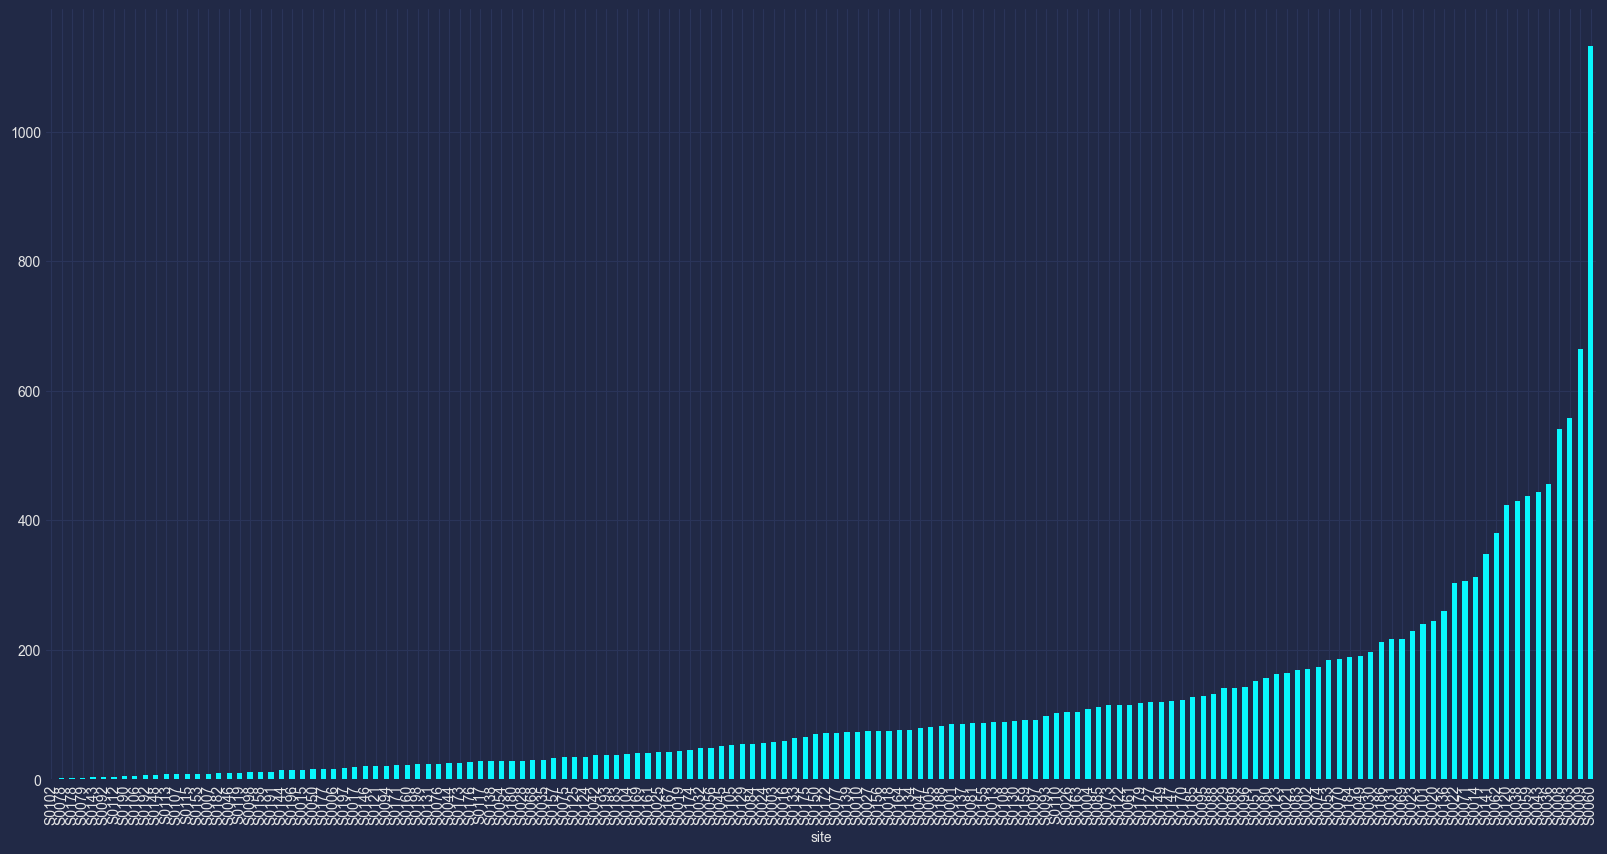

In [7]:
# plot the overall site distribution
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
df["site"].value_counts().sort_values().plot(kind="bar", ax=ax)

In [8]:
# # Plot animal distribution for each site

# m = df.site.nunique()

# for i, site in enumerate(df.site.unique()[:m]):
#     fig, ax = plt.subplots(1, 1)
#     sns.countplot(data=df[df["site"]==site], x="site", hue="animal_label", ax=ax)

In [9]:
df.animal_label.value_counts()

animal_label
monkey_prosimian    2492
antelope_duiker     2474
civet_genet         2423
leopard             2254
blank               2213
rodent              2013
bird                1641
hog                  978
Name: count, dtype: int64

In [10]:
sites_unique = df.site.unique()
N_sites_unique = sites_unique.shape[0]
sites_unique

array(['S0120', 'S0069', 'S0009', 'S0008', 'S0036', 'S0019', 'S0060',
       'S0047', 'S0083', 'S0059', 'S0076', 'S0014', 'S0080', 'S0061',
       'S0075', 'S0003', 'S0105', 'S0188', 'S0097', 'S0068', 'S0077',
       'S0038', 'S0049', 'S0170', 'S0063', 'S0071', 'S0062', 'S0073',
       'S0070', 'S0053', 'S0171', 'S0134', 'S0022', 'S0089', 'S0025',
       'S0042', 'S0021', 'S0184', 'S0027', 'S0026', 'S0004', 'S0024',
       'S0035', 'S0018', 'S0081', 'S0125', 'S0110', 'S0127', 'S0159',
       'S0051', 'S0112', 'S0108', 'S0074', 'S0157', 'S0155', 'S0122',
       'S0095', 'S0123', 'S0001', 'S0023', 'S0149', 'S0185', 'S0043',
       'S0088', 'S0130', 'S0186', 'S0124', 'S0031', 'S0046', 'S0136',
       'S0174', 'S0056', 'S0013', 'S0020', 'S0005', 'S0030', 'S0158',
       'S0156', 'S0016', 'S0084', 'S0179', 'S0096', 'S0137', 'S0163',
       'S0121', 'S0029', 'S0153', 'S0002', 'S0144', 'S0032', 'S0147',
       'S0104', 'S0175', 'S0176', 'S0050', 'S0093', 'S0133', 'S0146',
       'S0150', 'S01

In [11]:
print(np.random.choice(sites_unique, size=10, replace=False))
print(sites_unique.shape)

['S0136' 'S0093' 'S0083' 'S0169' 'S0107' 'S0017' 'S0186' 'S0188' 'S0193'
 'S0157']
(148,)


## Generate similar animal distributions for dataset containing disjoint site sets via the Kullback-Leibler divergence

### Generate the site lists

In [12]:
N_data = df.shape[0]  # total number of data instances

train_fraction = 0.8
val_fraction = 0.1
test_fraction = 1-(train_fraction+val_fraction)

In [13]:
# generate a Series containing the site counts (used in the loop for looking them up)
site_counts = df.groupby(by="site").id.count()
# site_counts

In [14]:
# # run some timing comparison tests for different permutation generation methods
# %timeit np.random.permutation(10)

# %timeit np.random.permutation(np.arange(10))  # probably also should be tested with pre-instantiation of the to-be-permuted array

# %timeit np.random.default_rng().permutation(10)

# rng = np.random.default_rng()
# %timeit rng.permutation(10)

# %timeit rng.shuffle(np.arange(10))  # probably also should be tested with pre-instantiation of the to-be-permuted array

In [15]:
# vectorized version

# run N_run site distribution experiments and check for the lowest reached maximum pairwise entropy

## initialize used lists
entropies__test_train = []
entropies__test_val = []
entropies__val_train = []
sites_KB_train = []
sites_KB_val = []
sites_KB_test = []

## set the number of runs
# N_runs = 1000
# N_runs = 10000  # done, takes 30 min ?
N_runs = 100000

for i in range(N_runs):

    n_run = i  # current run count
    run_percentage = n_run/N_runs  # current percentage of runs (done + in progress)
    if not n_run%int(N_runs/10):
    # if not run_percentage%
        print(f"Run {n_run} of {N_runs}")

    # generate random permutations of the array containing the unique sites
    sites_unique__indices__rand_perm = np.random.permutation(N_sites_unique)
    sites_unique__rand_perm = sites_unique[sites_unique__indices__rand_perm]

    # Get the number of data instance for each site in the randomly permuted sites array
    ## NOTE: this should be refactored in to look-up DataFrame outside the loss, such that is does not have to be computed in every iteration !!!
    # N_instances__sites_unique__rand_perm = np.array([df[df["site"]==random_site].shape[0] for random_site in sites_unique__rand_perm])
    ## refactored:
    N_instances__sites_unique__rand_perm = site_counts[sites_unique__rand_perm].to_numpy()  # this gave speed-up factor of approx. 10 !!!


    # calculate the cumulative sums in order to select subsets of the sites array
    N_instances__sites_unique__rand_perm__cumsum = np.cumsum(N_instances__sites_unique__rand_perm)

    # get the fractions with respect to the total number of data instance
    N_instances__sites_unique__rand_perm__cumsum__fraction = N_instances__sites_unique__rand_perm__cumsum/N_data
    # select sites via data splitting fraction criteria


    # select the sites for each dataset
    sites_train = sites_unique__rand_perm[N_instances__sites_unique__rand_perm__cumsum__fraction <= train_fraction]

    sites_val = sites_unique__rand_perm[np.logical_and(N_instances__sites_unique__rand_perm__cumsum__fraction > train_fraction,
                                                    N_instances__sites_unique__rand_perm__cumsum__fraction <= (train_fraction+val_fraction))]

    sites_test = sites_unique__rand_perm[N_instances__sites_unique__rand_perm__cumsum__fraction > (train_fraction+val_fraction)]
    ## alternative implementation: index with the array of indices returned by np.where()


    # create the actual data sets from the generated site attribution lists
    X_train = df.query("site in @sites_train")
    X_val = df.query("site in @sites_val")
    X_test = df.query("site in @sites_test")


    # generate the distributions by summing the one-hot encoded categorical data along the columns
    dist_train = X_train.iloc[:, 9:].sum(axis=0).to_numpy()
    dist_val = X_val.iloc[:, 9:].sum(axis=0).to_numpy()
    dist_test = X_test.iloc[:, 9:].sum(axis=0).to_numpy()

    # calculate the pairwise entropies for all data set pairs
    entropy_temp__test_train = entropy(dist_test, dist_train, axis=0)
    entropy_temp__test_val = entropy(dist_test, dist_val, axis=0)
    entropy_temp__val_train = entropy(dist_val, dist_train, axis=0)

    ## append the calculated entropies to the corresponding lists
    entropies__test_train.append(entropy_temp__test_train)
    entropies__test_val.append(entropy_temp__test_val)
    entropies__val_train.append(entropy_temp__val_train)

    ## append the corresponding sites to the lists
    sites_KB_train.append(sites_train)
    sites_KB_val.append(sites_val)
    sites_KB_test.append(sites_test)


Run 0 of 100000
Run 10000 of 100000
Run 20000 of 100000
Run 30000 of 100000
Run 40000 of 100000
Run 50000 of 100000
Run 60000 of 100000
Run 70000 of 100000
Run 80000 of 100000
Run 90000 of 100000


### some timing tests

In [50]:
# %timeit df.query("site in @sites_train")
# %timeit df.set_index("site").loc[sites_train]#.reset_index()[df.columns]
# # %timeit df.set_index("site").loc[sites_train].sort_values(by="id").reset_index()[df.columns]

In [51]:
# # check if both expression give the same (somplicated stuff is necessary for index- and column- and sorting-matching)
# df.set_index("site").loc[sites_train].sort_values(by="id").reset_index()[df.columns] == df.query("site in @sites_train").sort_values(by="id").reset_index(drop=True)

### Compute the entropies

In [16]:
# extract the site combinations with minimum maximum entropy
max_entropies = []
for tup in zip(entropies__test_train, entropies__test_val, entropies__val_train):
    # print(tup)
    max_entropies.append(max(tup))

idx_min_max_entropy = np.argmin(max_entropies)

## get the arrays
sites_KB_train__min_entropy = sites_KB_train[idx_min_max_entropy]
sites_KB_val__min_entropy = sites_KB_val[idx_min_max_entropy]
sites_KB_test__min_entropy = sites_KB_test[idx_min_max_entropy]

## create Series
sites_KB_train__min_entropy__Series = pd.Series(sites_KB_train__min_entropy)
sites_KB_val__min_entropy__Series = pd.Series(sites_KB_val__min_entropy)
sites_KB_test__min_entropy__Series = pd.Series(sites_KB_test__min_entropy)

In [17]:
# print the minimum maximum entropy value achieved
print("Minimum maximum entropy:", round(max_entropies[idx_min_max_entropy], 4))

Minimum maximum entropy: 0.0175


### Generate and save the datasets

In [18]:
# Generate the train, validation and test dataset info DataFrames

df_train = df.query("site in @sites_KB_train__min_entropy")
df_val = df.query("site in @sites_KB_val__min_entropy")
df_test = df.query("site in @sites_KB_test__min_entropy")

In [19]:
# save all results

dir_output_relative = "../data/dataset_infos/"  # the relative directory path to all data files

save_results = True

if save_results:
    sites_KB_train__min_entropy__Series.to_csv(dir_output_relative+f"sites_KB_train__min_entropy__{N_runs}_runs.csv", index=False, header=None)
    sites_KB_val__min_entropy__Series.to_csv(dir_output_relative+f"sites_KB_val__min_entropy__{N_runs}_runs.csv", index=False, header=None)
    sites_KB_test__min_entropy__Series.to_csv(dir_output_relative+f"sites_KB_test__min_entropy__{N_runs}_runs.csv", index=False, header=None)

    df_train.to_csv(dir_output_relative+f"train_dataset_info__{N_runs}_runs.csv", index=False)
    df_val.to_csv(dir_output_relative+f"val_dataset_info__{N_runs}_runs.csv", index=False)
    df_test.to_csv(dir_output_relative+f"test_dataset_info__{N_runs}_runs.csv", index=False)

### Inspect the results

In [20]:
# check the dataset fractions

print(f"Train set fraction: {df_train.shape[0]/N_data:.4f}")
print(f"Validation set fraction: {df_val.shape[0]/N_data:.4f}")
print(f"Test set fraction: {df_test.shape[0]/N_data:.4f}")

Train set fraction: 0.7857
Validation set fraction: 0.0999
Test set fraction: 0.1144


In [66]:
max_entropies_array = np.array(max_entropies)
max_entropies_array[max_entropies_array==np.inf] = np.nan
np.all(max_entropies_array)
np.inf in max_entropies_array

False

[(0.0, 1.0)]

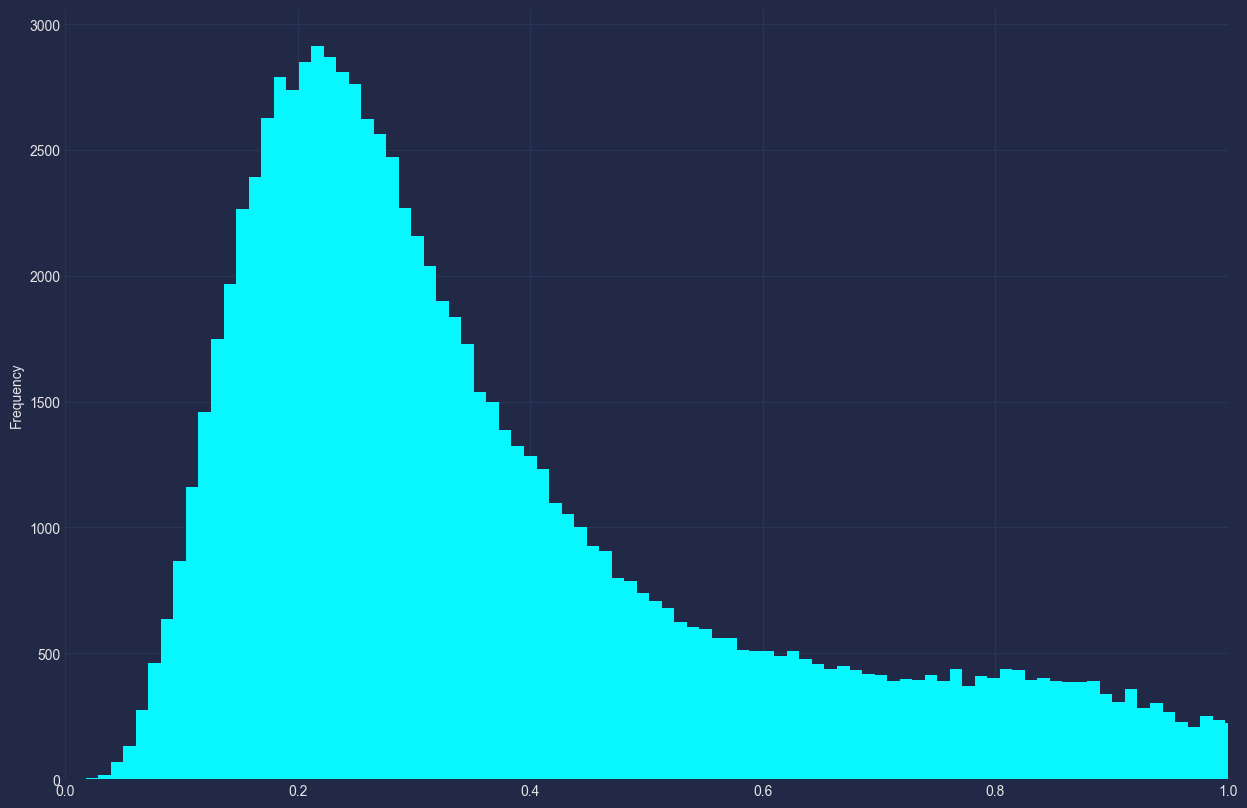

In [79]:
# plot the distribution of the maximum entropy values obtained
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
pd.Series(max_entropies_array).plot(kind = "hist",
                                    bins = int(np.sqrt(max_entropies_array.shape[0])),
                                    # bins = max_entropies_array.shape[0],
                                    ax = ax)
ax.set(xlim = [0, 1],
    #    xlim = [0, .1],
    #    ylim = [0, 100]
       )

<Axes: >

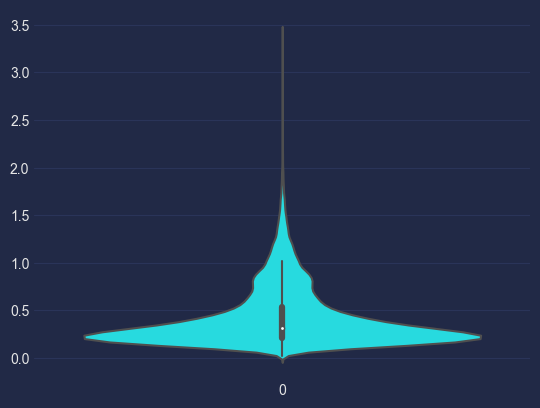

In [68]:
sns.violinplot(data=pd.Series(max_entropies_array))

/var/folders/vg/z5mcy3k171qcx_mqd9slybl00000gn/T/ipykernel_46333/806184216.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


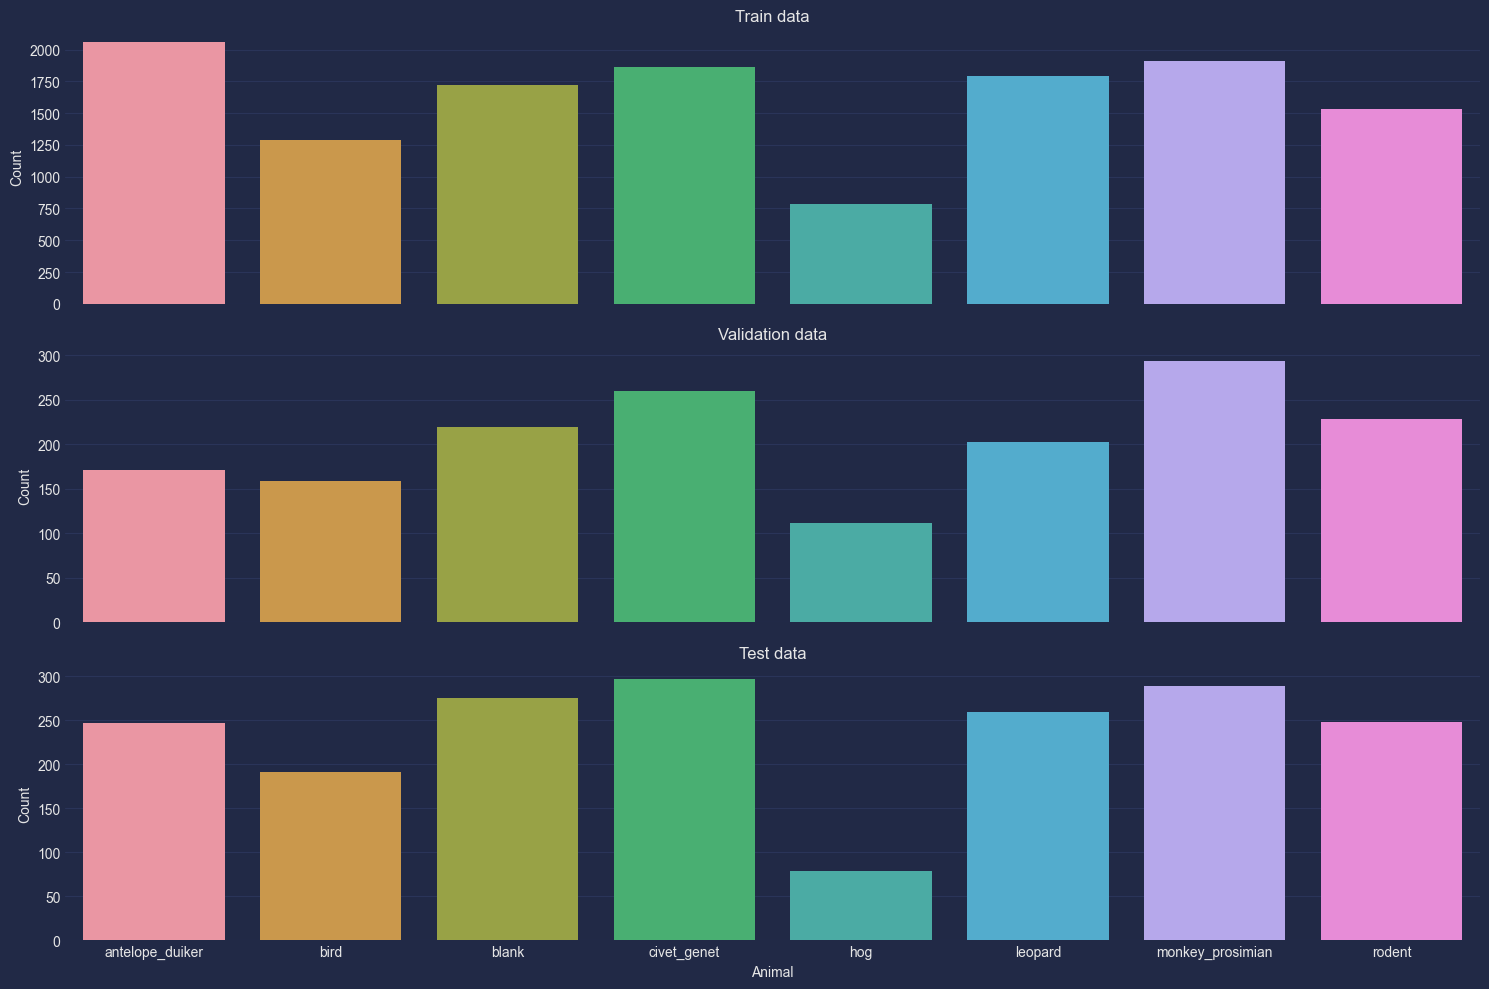

In [21]:
# plot the distributions for visual comparison

fig, ax = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

sns.countplot(data=df_train.sort_values(by='animal_label'), x="animal_label", ax=ax[0])
sns.countplot(data=df_val.sort_values(by='animal_label'), x="animal_label", ax=ax[1])
sns.countplot(data=df_test.sort_values(by='animal_label'), x="animal_label", ax=ax[2])

ax[0].set(title="Train data",
          xlabel="",
          ylabel="Count")
ax[1].set(title="Validation data",
          xlabel="",
          ylabel="Count")
ax[2].set(title="Test data",
          xlabel="Animal",
          ylabel="Count")

fig.tight_layout()
fig.show()

if save_results:
    fig.savefig(dir_output_relative+f"distribution_comparison__{N_runs}_runs.png", dpi=300)